<a href="https://colab.research.google.com/github/G4TW/fouraigithub/blob/master/Copy_of_BFDAI_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BFDI Voice Synthesis**
![alt text](https://vignette.wikia.nocookie.net/battlefordreamisland/images/3/3c/Lololjhk.gif/revision/latest?cb=20180429221218)

-----------------------------------------------------------
Here's an easier way to use the BFDAI voices!  Credit to Cookie for most of the code.

**Note**: Sometimes the models will have a hard time pronouncing stuff, so if you're able to, make sure to use ARPAbet. You can also try to spell words differently to get the TTS to pronounce it. 

Make sure to wrap the ARPAbet like this: {T EH1 S T}

**ARPAbet Translator (Show Lexical Stress)**: http://www.speech.cs.cmu.edu/cgi-bin/cmudict

OR

**Merged Dictionary**: https://drive.google.com/open?id=13ciybUBArMtk4fBPcQnVIjkFrGzpkN0E

-----------------------------------------------------------

## Install and Initialize Tacotron2 and Waveglow repo and MEGA Downloader

In [1]:
#@title
!git clone https://github.com/jeroenmeulenaar/python3-mega.git
!(cd python3-mega; pip install urlobject pycrypto)
 
import os
os.chdir('python3-mega')
from mega import Mega
os.chdir('../')
m = Mega.from_ephemeral()
print("Downloading Dictionary...")
m.download_from_url('https://mega.nz/#!yAMyFYCI!o_UmixbiIzosyYk-6O5xRZZDGpFRik_eMrZum-iQuhQ')

Cloning into 'python3-mega'...
remote: Enumerating objects: 118, done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 118
Receiving objects: 100% (118/118), 21.60 KiB | 124.00 KiB/s, done.
Resolving deltas: 100% (61/61), done.
     |████████████████████████████████| 450kB 5.3MB/s 
  Created wheel for urlobject: filename=URLObject-2.4.3-cp36-none-any.whl size=14533 sha256=51072fd17575201c1e493999b5364f7bcc3311f5abf296f264f9f6d7ea5b0ac0
  Stored in directory: /root/.cache/pip/wheels/fd/7e/18/ccb55ecc2834f945b769c1ff1df12ca5a14400ccfc58e3c515
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp36-cp36m-linux_x86_64.whl size=499939 sha256=8435a5b0646c1866b3bb0e1e0f28e32c6f4e15deccf7163ef3e8c37007933d0a
  Stored in directory: /root/.cache/pip/wheels/27/02/5e/77a69d0c16bb63c6ed32f5386f33a2809c94bd5414a2f6c196
Successfully built urlobject pycrypto


In [2]:
#@title
%matplotlib inline
!nvidia-smi -L
!nvidia-smi
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext
!pip install gdown
git_repo_url = 'https://github.com/CookiePPP/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 2fd4e63
  !pip install -q librosa unidecode
 
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
import gdown
import IPython.display as ipd
import numpy as np
import torch
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser
from unidecode import unidecode
from random import choice
import librosa
d = 'https://drive.google.com/uc?id='
 
def plot_data(data, info=None):
    %matplotlib inline
    fig, axes = plt.subplots(1, len(data), figsize=(int(alignment_graph_width*graph_scale/100), int(alignment_graph_height*graph_scale/100)))
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='inferno')
    axes[0].set(xlabel="Frames", ylabel="Channels")
    axes[1].set(xlabel="Decoder timestep", ylabel="Encoder timestep")
    fig.canvas.draw()
    plt.show()
 
def ARPA(text):
    out = ''
    for word_ in text.split(" "):
        word=word_; end_chars = ''
        while any(elem in word for elem in r"!?,.;") and len(word) > 1:
            if word[-1] == '!': end_chars = '!' + end_chars; word = word[:-1]
            if word[-1] == '?': end_chars = '?' + end_chars; word = word[:-1]
            if word[-1] == ',': end_chars = ',' + end_chars; word = word[:-1]
            if word[-1] == '.': end_chars = '.' + end_chars; word = word[:-1]
            if word[-1] == ';': end_chars = ';' + end_chars; word = word[:-1]
            else: break
        try: word_arpa = thisdict[word.upper()]
        except: word_arpa = ''
        if len(word_arpa)!=0: word = "{" + str(word_arpa) + "}"
        out = (out + " " + word + end_chars).strip()
    if out[-1] != "␤": out = out + "␤"
    return out
 
!mkdir tacotron2/infer
thisdict = {}   # And load it
for line in reversed((open('merged.dict_1.1.txt', "r").read()).splitlines()):
    thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

GPU 0: Tesla K80 (UUID: GPU-d30cdd24-48f0-7ded-6c83-6a6d7a051051)
Sat Jul 11 05:24:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                      

## Setup Tacotron 2 Model
----

Here is where you can pick out one of the models.

To change the model, use the dropdown.

In [4]:
Voice = "Four V3" #@param ["Four V3", "X V2", "Two", "Four V2", "Four V1", "X V1"]

In [5]:
#@title
vid =""
if Voice=="Four V3":
    vid = '1Lej9KoOi8N_NBLAe1pWgU2K16LxfBRIV'
if Voice=='X V2':
    vid = '1a9uMtlxEFIECAIgR6sGYXAUqjqrQRsqy'
if Voice=='Two':
    vid = '1sew4iilpij9tvY8HTEYKZuik0BMMf8vX'
if Voice=='Four V2':
    vid = '1-I2C5Fy7nirEBS7ZApraCYLiUsuZEQuJ'    
if Voice=='Four V1':
    vid = '1xraWJnM4qAqhbcTJZ6L-IL8-KYX3EioW'  
if Voice=='X V1':
    vid = '1AeLT-PVsEmRVt2-jMnAXQ0lCF0_N-0db'  
     
#["Four V3", "X", "Two", "Four V2", "Four V1"]

In [6]:
#@title
# Download Tacotron 2 Model
force_download_TT2 = True
tacotron2_pretrained_model = 'MLPTTS'
if not exists(tacotron2_pretrained_model) or force_download_TT2:
                   # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ Change this to pick a voice.
  gdown.download(d+vid, tacotron2_pretrained_model, quiet=False); print("Tacotron2 Model Downloaded")
                   # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ Change this to pick a voice.
 
# Setup Parameters
hparams = create_hparams()
hparams.sampling_rate = 48000
hparams.max_decoder_steps = 3000 # how many steps before cutting off generation, too many and you may get CUDA errors.
hparams.gate_threshold = 0.50 # Model must be 50% sure the clip is over before ending generation
# Load Tacotron2 model into GPU
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval().half()
print("This Tacotron model has been trained for ",torch.load(tacotron2_pretrained_model)['iteration']," Iterations.")

384MB [00:02, 183MB/s]


Tacotron2 Model Downloaded
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

This Tacotron model has been trained for  1944  Iterations.


## Setup WaveGlow Model
----
**This section does not need to be modified unless you see "`WaveGlow failed to download on all ID's provided`" on the output.**

---

Right now Google may deny permissions, presumably too many downloads.
Goto [this](https://drive.google.com/uc?id=1p-GmnYiSS9UsRjw13kkhbIoD0-9t8ALH) link and you can clone the file into your down drive. Click 'Get Sharable Link' and extract the id.

`https://drive.google.com/open?id=1DMyL3RxFqAVhH60VCLnVaDt2YJb2RCfz`

In this example, the id is `1DMyL3RxFqAVhH60VCLnVaDt2YJb2RCfz`. That can be added to the waveglow_ids list or just replace one of the ids already there.

In [7]:
#@title
# Download WaveGlow Model
waveglow_pretrained_model = 'waveglow.pt'
waveglow_ids = ['1DMyL3RxFqAVhH60VCLnVaDt2YJb2RCfz', '10wDUQ3HAKhdNgnqZC3PBDBZ12PADZWAU', '14ajSxb4yJXQnv_nf9O89dIWcfdvUFFZo', '1H707kelxad-DuWBBmDGgR48b5KCS0ta8', '1lDzc_asOMCrf86XcfHKTSCnYBojb0VR-', '1Rmm81f6-NJQ-6T2JCtwS6XZedrrXoW0E', '1sMYb2HixSOSEHR1mOoBkXMHOlJ4vAV-m', 'https://drive.google.com/open?id=1lDRZtuPoYObMen9klwSIQPQ5lLkpp3mi', 'https://drive.google.com/open?id=1F__M3bwVuZkeHFULkoQgef8QB5Tx6_24', 'https://drive.google.com/open?id=14DJNfpPUnSNOfamRQzKgqaU4Y87zE3-c', 'https://drive.google.com/open?id=1_AjAgDGm_bf0t4-yznCoD0foPKyp4YPW']
while not exists(waveglow_pretrained_model) and waveglow_ids:
    id = choice(waveglow_ids)
    gdown.download(d+id, waveglow_pretrained_model, quiet=False);
    if not exists(waveglow_pretrained_model): print("Download Failed, attempting another ID"); waveglow_ids.remove(id)
if exists(waveglow_pretrained_model): print("WaveGlow Downloaded")
else: print("WaveGlow failed to download on all ID's provided")
 
# Load WaveGlow model into GPU
waveglow = torch.load(waveglow_pretrained_model)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)
print("This WaveGlow model has been trained for ",torch.load(waveglow_pretrained_model)['iteration']," Iterations.")

Downloading...
From: https://drive.google.com/uc?id=1Rmm81f6-NJQ-6T2JCtwS6XZedrrXoW0E
To: /content/waveglow.pt
1.48GB [00:26, 56.5MB/s]


WaveGlow Downloaded
This WaveGlow model has been trained for  339458  Iterations.


Choose what you want the AI to say!

Rawopt is an advanced setting.  If it's set to true, you can insert ARPABET phonemes.

In [8]:
Text = "four" #@param {type:"string"}
Rawopt = False #@param {type:"boolean"}

**Note**: Sometimes the model won't generate the text perfectly, or sometimes you won't get the emotion you want. If that happens, try re-generating it.

Also the model can't handle really, really long text. It can handle some long text, but anything really long, you'll have to break it up into parts.

## Click the last play button and you're done!

four
{F AO1 R}␤


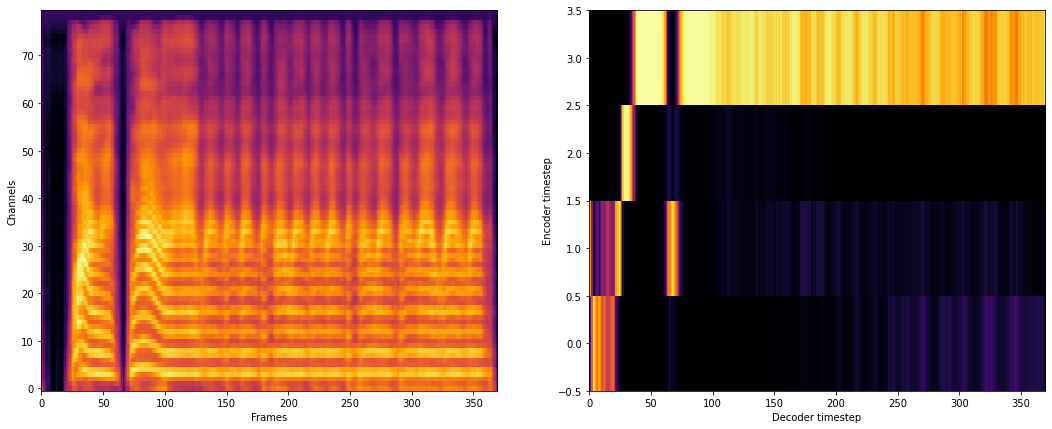

Denoised


In [9]:
#@title
text = Text
 
sigma = 0.75
denoise_strength = 0.01
raw_input_ = Rawopt  # disables automatic ARPAbet conversion, useful for inputting your own pronounciation or just for testing 
 
show_graphs = True
graph_scale = 1 # literally a zoom factor
alignment_graph_width = 1800
alignment_graph_height = 720
 
save_wavs = 1
counter = 0
text = unidecode(text) # convert unicode punctuation into it's normal equivalents (thanks Fimfiction.)
text = text * 1 # how many times to generate each clip
with torch.no_grad():
    for i in text.split("\n"):
        if len(i) < 1: continue;
        print(i)
        if raw_input_:
            if i[-1] != "␤": i=i+"␤" 
        else: i = ARPA(i)
        print(i)
        sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
        if show_graphs:
            plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                alignments.float().data.cpu().numpy()[0].T))
        audio = waveglow.infer(mel_outputs_postnet, sigma=sigma); print(""); ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        audio_denoised = denoiser(audio, strength=denoise_strength)[:, 0]; print("Denoised"); ipd.display(ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate))
        if save_wavs:
            librosa.output.write_wav('tacotron2/infer/Inf_' + str(counter) + '.wav', np.swapaxes(audio_denoised.cpu().numpy(),0,1), hparams.sampling_rate)
        counter+=1

The rest is just examples of good alignment. See to the graphs on the right?

Those graphs need to look as close to this 

![Image of Alignment Graph. Basically Perfect alignment, there's no point going above this level](https://i.ibb.co/TKSQz7h/perfect-alignment.png)

as possible.